# Plant Leaf Disease Classification using Pretrained CNN and SVM 


# 1. IMPORT LIBRARIES

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D



# 2. Extract Data and EDA 

In [3]:
DATASET_DIR = "/kaggle/input/plantdisease/PlantVillage"


In [4]:
classes = os.listdir(DATASET_DIR)
print("Number of classes:", len(classes))

Number of classes: 15


In [5]:
print(classes)

['Pepper__bell___Bacterial_spot', 'Potato___healthy', 'Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight', 'Tomato__Target_Spot', 'Pepper__bell___healthy', 'Potato___Late_blight', 'Tomato_Late_blight', 'Potato___Early_blight', 'Tomato__Tomato_mosaic_virus']


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


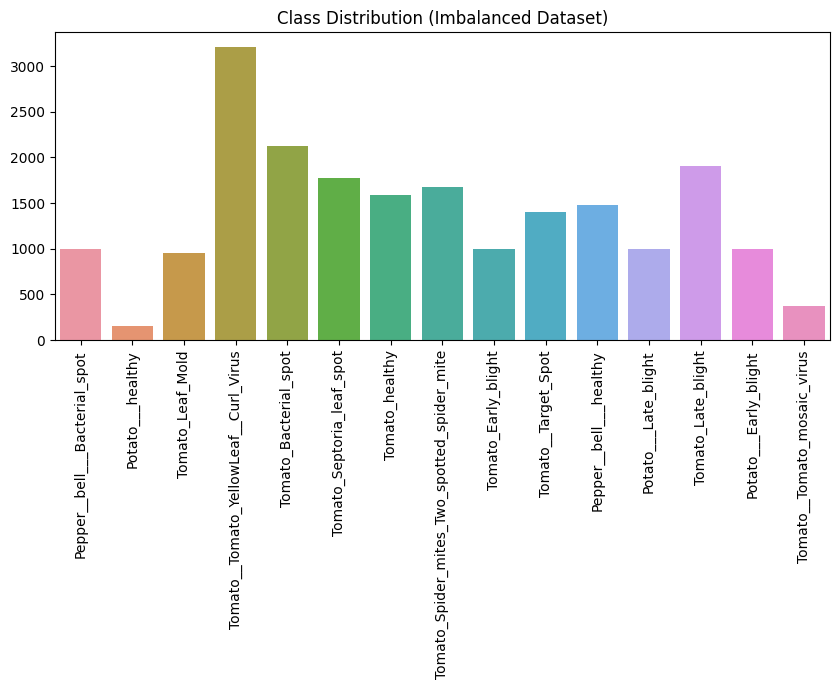

In [6]:
class_counts = {cls: len(os.listdir(os.path.join(DATASET_DIR, cls))) for cls in classes}

plt.figure(figsize=(10,4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.title("Class Distribution (Imbalanced Dataset)")
plt.show()


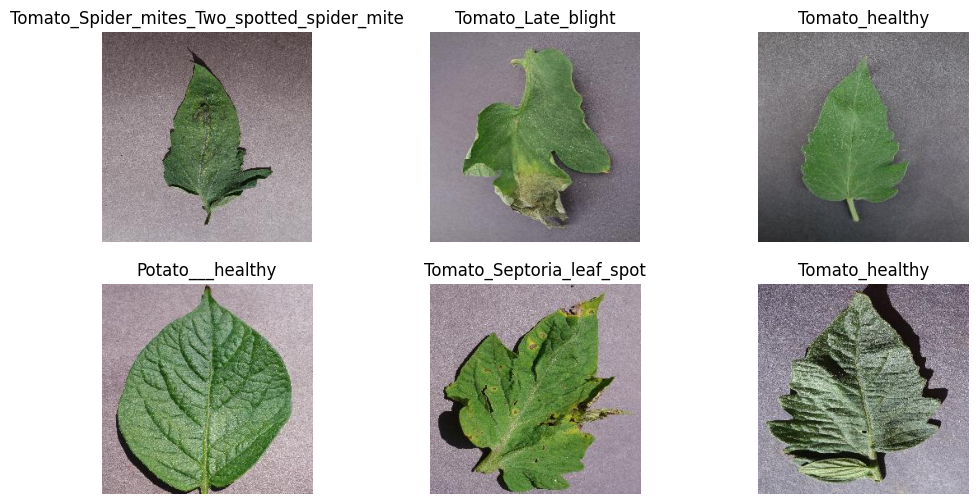

In [7]:
def show_sample_images():
    plt.figure(figsize=(12,6))
    for i, cls in enumerate(np.random.choice(classes, 6)):
        img_path = os.path.join(DATASET_DIR, cls, 
                                np.random.choice(os.listdir(os.path.join(DATASET_DIR, cls))))
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2,3,i+1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")
    plt.show()

show_sample_images()


# 3. Image Loading & Cleaning

In [8]:
def load_images(dataset_dir, img_size=224):
    images = []
    labels = []
    
    for cls in os.listdir(dataset_dir):
        cls_path = os.path.join(dataset_dir, cls)
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (img_size, img_size)) 
                images.append(img)
                labels.append(cls)
            except:
                pass
    
    return np.array(images), np.array(labels)

X, y = load_images(DATASET_DIR, IMG_SIZE)

print("Images shape:", X.shape)


Images shape: (20638, 224, 224, 3)


# 4. Encode Labels & Train/Test Split

In [9]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 5. Load EfficientNet as Feature Extractor

In [10]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)



I0000 00:00:1765987555.097783      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765987555.098350      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
feature_extractor = Model(inputs=base_model.input, outputs=x)

In [12]:
feature_extractor.trainable = False

# 6. Feature Extraction

In [13]:
X_train_pre = preprocess_input(X_train)
X_test_pre = preprocess_input(X_test)

train_features = feature_extractor.predict(X_train_pre, batch_size=32)
test_features = feature_extractor.predict(X_test_pre, batch_size=32)

print("Feature vector shape:", train_features.shape)


I0000 00:00:1765987568.224584     114 service.cc:148] XLA service 0x78e624088fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765987568.225350     114 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765987568.225370     114 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765987568.916505     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/516 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step

I0000 00:00:1765987574.208003     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


516/516 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step
Feature vector shape: (16510, 1280)


# 7. Machine Learning Classifier (SVM)

In [14]:
svm_model = SVC(kernel="rbf", probability=True)
svm_model.fit(train_features, y_train)


SVC(probability=True)

# 8. Evaluation

In [15]:
y_pred = svm_model.predict(test_features)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.9665697674418605
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      0.98      0.99       199
                     Pepper__bell___healthy       0.99      1.00      0.99       296
                      Potato___Early_blight       0.99      0.99      0.99       200
                       Potato___Late_blight       0.98      0.95      0.97       200
                           Potato___healthy       0.91      0.97      0.94        30
                      Tomato_Bacterial_spot       0.96      1.00      0.98       426
                        Tomato_Early_blight       0.91      0.90      0.91       200
                         Tomato_Late_blight       0.96      0.97      0.97       382
                           Tomato_Leaf_Mold       0.95      0.94      0.94       190
                  Tomato_Septoria_leaf_spot       0.96      0.93      0.95       354
Tomato_Spider_mites_Two_spotted_spi

In [16]:
import joblib

joblib.dump(svm_model, "svm_plant_disease.pkl")
feature_extractor.save("efficientnet_feature_extractor.keras")


- Cleaned and prepared an imbalanced dataset
- Used EfficientNet for deep feature extraction
- Applied SVM for classification (Hybrid Model)
- Achieved strong performance with reduced training cost